<a href="https://colab.research.google.com/github/scrambler07/AI-ML_project/blob/main/Stockprice_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade yfinance

## 1. Import Libraries

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## 2. Fetch Data

In [ ]:
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end='2024-12-31')
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


# Add Technical Indicators

In [ ]:
data['MA20'] = data['Close'].rolling(window=20).mean()
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))
data = data.dropna()

## 3. Normalize Data

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

## 4. Create Dataset Function

In [ ]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [ ]:
time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

## 5. Split into Train/Test

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 6. Build LSTM Model

In [ ]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.3))
model.add(LSTM(50))
model.add(Dropout(0.3))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

## 7. Train the Model

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0188 - val_loss: 7.4892e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 0.0014 - val_loss: 0.0051
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0014 - val_loss: 8.5259e-04
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0011 - val_loss: 8.2879e-04
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0011 - val_loss: 6.5194e-04
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 12/100
61/61 ━━━━━━━━━━━━━━

## 8. Make Predictions

In [ ]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


## 9. Evaluate the Model

In [ ]:
mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 15.1889, MAE: 3.0376


## 10. Plot Predictions vs Actual

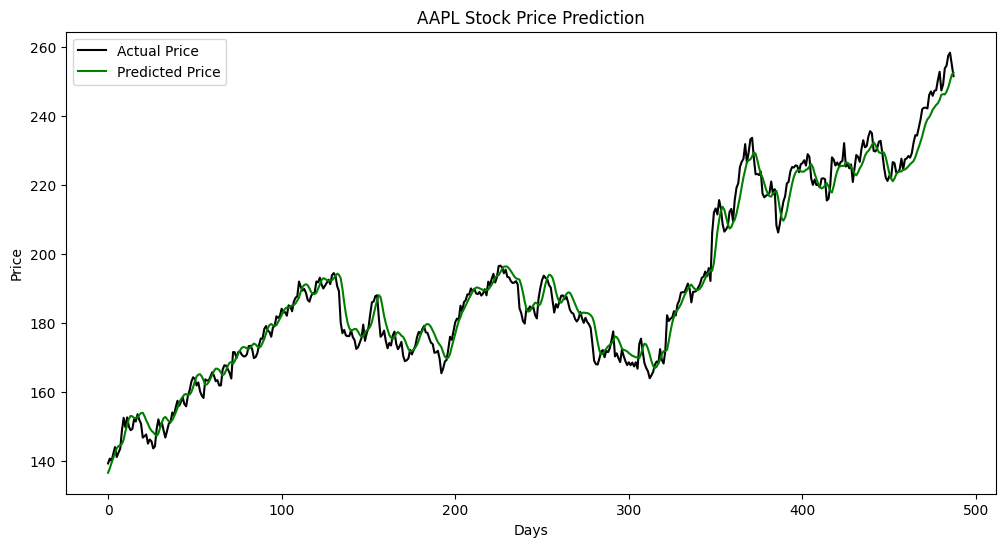

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price', color='black')
plt.plot(predicted_prices, label='Predicted Price', color='green')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

## 11. Predict Next Day Price

In [ ]:
last_sequence = scaled_data[-time_step:].reshape(1, time_step, 1)
future_price = model.predict(last_sequence)
print("Next day predicted price:", scaler.inverse_transform(future_price)[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Next day predicted price: 251.6441


## 12. Save Model

In [ ]:
model.save("stock_price_lstm_model.h5")